# Assignment 3 - Sequence Tagging

In this assignment we are going to develop two models for sequence tagging (labeling). As we learned in class, in sequence tagging we have an input sequence X = x1 ... xn and the goal is to assign a label (tag) yi to each word xi in the sequence.

We will develop (1) a Hidden Markov Model (HMM) and (2) an RNN-based sequence tagger. We will also implement decoding with the Viterbi algorithm, since as we saw in class, greedily assigning the most likely tag for each token can result in a suboptimal sequence of POS tags.

![](https://drive.google.com/uc?export=view&id=1HdBAFpMMEXQxhdLJfs4eAPZNXv_47ngz)



### Loading the Dataset

If you're working in Colab, make sure you upload the file `corpus.txt` to the working directory.

We will load and save the `corpus.txt` POS-annotated corpus in a format different from its origianl one. In the file, each word is followed by an underscore and a tag that represents the word's correct part of speech in that context. For instance:

<br>

*(1) There_EX are_VBP also_RB plant_NN and_CC gift_NN shops_NNS ._.*

*(2) Tosco_NNP said_VBD it_PRP expects_VBZ BP_NNP to_TO shut_VB the_DT plant_NN ._.*

<br>

We will instead reformat and load the same info as (token, pos_tag) lists. For example:

<br>

[
  [(there, EX), (are, VBP), (also, RB), (plant, NN), (and, CC), (gift, NN), (shop, NNS), (., .)],

  [(tosco, NNP), (said, VBD), (it, PRP), (expects, VBZ), (BP, NNP), (to, To), (shut, VB), (the, DT), (plant, NN), (., .)]
]

<br>

**Please note that we convert each token into its lower case.**

In [1]:
dataset = [[tuple(w.split('_')) for w in line.strip().split()]
           for line in open("corpus.txt")]

# Lowercase the words
dataset = [[(w.lower(), pos) for (w, pos) in sentence] for sentence in dataset]
print(dataset[0])

[('brainpower', 'NNP'), (',', ','), ('not', 'RB'), ('physical', 'JJ'), ('plant', 'NN'), (',', ','), ('is', 'VBZ'), ('now', 'RB'), ('a', 'DT'), ('firm', 'NN'), ("'s", 'POS'), ('chief', 'JJ'), ('asset', 'NN'), ('.', '.')]


## Part 1 - Count-based Sequence Tagging with Viterbi Algorithm

In the first part of this assignment, we will build a hidden Markov nodel to predict the part of speech tags for the words in a given sentence, using the *Viterbi Algorithm* (see textbook sec 8.4.5). In class we learned about the *Forward Algorithm* and Viterbi is a slight variation of that.

![](https://drive.google.com/uc?export=view&id=1Hf0LEE9cvJTbetDcdlzgordreff0u1av)

We start by obtaining the set of states for the HHM (the POSs) and set of observations (the tokens).

In [2]:
observations = sorted(list(set.union(*[set(list(zip(*line))[0]) for line in dataset])))
example = observations[:5] + ["..."] + observations[-5:]
print(f"Number of observations: {len(observations)}. {example}")

states = sorted(list(set.union(*[set(list(zip(*line))[1]) for line in dataset])))
example = states[:5] + ["..."] + states[-5:]
print(f"Number of states: {len(states)}. {example}")

Number of observations: 7602. ['$', '%', '&', "'", "''", '...', 'zoological', 'zurich', 'zwetsche', 'zyrtec', '~']
Number of states: 40. ['$', "''", ',', '-LRB-', '-RRB-', '...', 'WDT', 'WP', 'WP$', 'WRB', '``']


We would need to deal with out-of-vocabulary tokens that may appear during inference time (e.g. on a held-out test set). We solve this by adding an unknown token `<unk>` to the vocabulary (i.e., set of observations). In order for this token to get emission probabilities, we would need to add it into the dataset. We do so by replacing every token that appeared less than 2 times in the dataset with the `<unk>` token. Complete the code below to implement this solution.


In [3]:
####################################
#   Your code here
####################################
from collections import defaultdict

# replaced_words = set()
count_dict = defaultdict(int)
# count the frequencies
for i, line in enumerate(dataset):
    for (word, tag) in line:
        count_dict[word] = count_dict[word] + 1

for i, line in enumerate(dataset):
    for j, (word, tag) in enumerate(line):
        if count_dict[word] < 2:
            dataset[i][j] = ("<unk>", dataset[i][j][1])

# Update the observations
observations = sorted(list(set.union(*[set(list(zip(*line))[0]) for line in dataset])))
####################################

# Print <unk> frequency
print(sum([1 if w == "<unk>" else 0 for instance in dataset for w, _ in instance]))

3137


We are now ready to compute the emission probabilities. The emission probability matrix can be formed as a dictionary where the key is the POS tag, and the value is another dictionary, from a token to a probability. We will use MLE, i.e. the probability is computed as relative frequency, and we will apply add-1 smoothing to avoid 0 probabilities. Complete the code below. Don't forget to add the unobserved words in the smoothed probability distribution for each POS!

In [4]:
####################################
#   Your code here
####################################
emission_probability = defaultdict(lambda: defaultdict(int))
# count the observations after the <unk>
for line in dataset:
    for word, tag in line:
        emission_probability[tag][word] = emission_probability[tag][word] + 1

for state in states:
    count_sum = sum(emission_probability[state].values())
    for observation in observations:
        emission_probability[state][observation] = (emission_probability[state][observation] + 1) / (count_sum + len(observations))
        

####################################

print(f"Emission probability of 'money' in noun: {emission_probability['NN']['money']}")
print(f"Emission probability of 'yellow' in verb: {emission_probability['VB']['yellow']}")

Emission probability of 'money' in noun: 0.0019270298047276465
Emission probability of 'yellow' in verb: 0.0001547029702970297


Now, let's compute the transition probabilities. The transition matrix can be similarly formed as a dictionary, this time from a state (pos) to a dictionary of states to probabilities. Complete the code below to compute the MLE probabilities with Add-1 smoothing. Again, don't forget to include the probabilities from each state to each state (not only those that occurred in the data!).

In [5]:
####################################
#   Your code here
####################################
transition_probability = defaultdict(lambda: defaultdict(int))

for line in dataset:
    for j in range(len(line) - 1):
        curr_state, next_state = line[j][1], line[j+1][1]
        transition_probability[curr_state][next_state] = transition_probability[curr_state][next_state] + 1

for curr_state in states:
    curr_count = sum(transition_probability[curr_state].values())
    for next_state in states:
        transition_probability[curr_state][next_state] = (transition_probability[curr_state][next_state] + 1) / (curr_count + len(states))


####################################

print(f"Transition probability from determiner to noun: {transition_probability['DT']['NN']}")
print(f"Transition probability from verb to adjective: {transition_probability['VB']['JJ']}")   

Transition probability from determiner to noun: 0.5064011379800853
Transition probability from verb to adjective: 0.05299313052011776


Finally, we can similarly compute the start probabilities. This will be a dictionary from POS to a probability.

In [6]:
####################################
#   Your code here
####################################
start_probability = defaultdict(int)

for line in dataset:
    start_state = line[0][1]
    start_probability[start_state] = start_probability[start_state] + 1


count = len(dataset)
for state in states:
    start_probability[state] = (start_probability[state] + 1) / (count + len(states))


####################################

print(f"Start probability for determiner: {start_probability['DT']}")
print(f"Start probability for verb: {start_probability['VB']}")

Start probability for determiner: 0.2650442477876106
Start probability for verb: 0.0017699115044247787


We're done estimating the probabilities! Now we can implement the decoding method, i.e. find the most probable sequence of POS tags for a given sentence (i.e. sequence of tokens). We will do this by implementing the Viterbi algorithm (see J&M section 8.4.5). Complete the following code.

In [7]:
import numpy as np


def Viterbi(curr_observations, # a sequence of tokens to decode
            states, start_prob, trans_prob, em_prob):

    T = len(curr_observations)

    # Create a probability matrix, viterbi, to denote the probability
    # to be in state s in time step t
    viterbi = {s: [0] * T for s in states}

    # Create the backpointer matrix that saves the previous state
    backpointer = {s: [0] * T for s in states}

    # Initialization step: set the path probability to the start probability
    # of the first state * emission probability of the first token.
    for s in states:
      viterbi[s][0] = start_prob[s] * em_prob[s][curr_observations[0]]

    # Recursion step: the probability is the maximum probability
    # of transitioning from s_other in time step t-1.

    for t in range(1, T):
      for s in states:
        ####################################
        #   Your code here
        ####################################
        s_other = states[np.argmax([viterbi[s_prime][t-1] * trans_prob[s_prime][s] * em_prob[s][curr_observations[t]] for s_prime in states])]
        ####################################

        backpointer[s][t] = s_other
        viterbi[s][t] = viterbi[s_other][t-1] * trans_prob[s_other][s] * em_prob[s][curr_observations[t]]

    # Termination step: find the most likely state at time step t and trace back
    # to find the path.
    s_end = states[np.argmax([viterbi[s][T-1] for s in states])]
    best_prob = viterbi[s_end][T-1]

    best_path = [s_end]
    for t in range(T-1, 0, -1):
      best_path.append(backpointer[best_path[-1]][t])

    best_path = best_path[::-1]
    return best_path, best_prob


print(Viterbi("I want to find this".lower().split(),
              states, start_probability,
              transition_probability, emission_probability))

(['PRP', 'VBP', 'TO', 'VB', 'DT'], 6.077387809681382e-15)


## Part 2 - LSTM-Based POS Tagger

In the second part of this assignment, we will use the same corpus to train a bidirectional stacked LSTM-based neural sequence labeling model to predict the part of speech tags of unknown input sentences.

The following figure shows an RNN-based sequence tagger:

![](https://drive.google.com/uc?export=view&id=1Hf79ROO3UU8BuePuacjhskYJrIq4lvr_)

The inputs at each time step are (possibly pre-trained) word embeddings corresponding to the input tokens. They go into the RNN (e.g. LSTM in our assignment) and the outputs from the RNN at each time step represent go into a softmax layer to produce the distribution over the POS tagset for the given input.

First, let's import the required packages.


In [8]:
import math
import tqdm
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from sklearn.metrics import f1_score
from torch.nn.utils import clip_grad_norm_

Since we are training a model, we should now split the dataset into train, dev, and test sets, with the common 80%-10%-10% ratio. We start by shuffling the dataset to avoid any possible ordering bias.

In [9]:
import random

random.shuffle(dataset)

training_data = dataset[0:math.floor(len(dataset)*0.8)]
dev_data = dataset[math.floor(len(dataset)*0.8):math.floor(len(dataset)*0.9)]
test_data = dataset[math.floor(len(dataset)*0.9):]

Next, we need to map tokens to indices so that we can learn the embeddings for each token. Similarly, we need to construct a dictionary of POS tags to indices. We will use the `Vocabulary` class from assignment 1. We will also create a `Corpus` class but adapt it to sequence tagging.

As in part 1, we also need to deal with **unknown tokens** in testing, for which we will adapt these classes. Complete the code below to replace each (w, p) in the data to their respective IDs, and replace words that appeared fewer than 2 times with the `<unk>` token. Each instance in `corpus.data` should return a tuple with two items: a list of word IDs and a list of tag IDs.

In [10]:
from itertools import count
from collections import defaultdict


class Vocabulary(object):
    def __init__(self, add_unk=False):
        self.word2idx = defaultdict(count(0).__next__)
        self.add_unk = add_unk

        if add_unk:
          _ = self.word2idx["<unk>"]

    def add_word(self, word):
        _ = self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

    def idx2word(self):
        return {i: w for w, i in self.word2idx.items()}


class Corpus(object):
    def __init__(self, data, vocab=None, tagset=None):
        # Only initialize for the train corpus.
        # Then, for the dev and test corpus, use the vocabulary
        # from the training set
        if vocab is None:
          self.vocab = Vocabulary(add_unk=True)
        else:
          self.vocab = vocab

        if tagset is None:
          self.tagset = Vocabulary(add_unk=False)
        else:
          self.tagset = tagset

        ####################################
        #   Your code here
        ####################################
        # add <unk> values
        count_dict = defaultdict(int)
        # count the frequencies
        for i, line in enumerate(data):
          for (word, tag) in line:
            count_dict[word] = count_dict[word] + 1

        out_data = []
        for i, line in enumerate(data):
          word_ids, tag_ids = [], []
          for j, (word, tag) in enumerate(line):
            if count_dict[word] < 2:
              data[i][j] = ("<unk>", tag)
            self.vocab.add_word(data[i][j][0])
            self.tagset.add_word(tag)
            word_ids.append(self.vocab.word2idx[data[i][j][0]])
            tag_ids.append(self.tagset.word2idx[tag])
          out_data.append([word_ids, tag_ids])
        data = out_data
        ####################################

        self.data = data

Now, let's create the `Corpus` object for each of the train, dev, and test sets.

In [11]:
train = Corpus(training_data)
dev = Corpus(dev_data, vocab=train.vocab, tagset=train.tagset)
test = Corpus(test_data, vocab=train.vocab, tagset=train.tagset)

print(f"Vocabulary size: {len(train.vocab)} words. Tag set size: {len(train.tagset)}.")

Vocabulary size: 3910 words. Tag set size: 40.


Now let's design the architecture of our bidirectional stacked LSTM-based POS tagger. It should consist of three layers:

* [Embedding layer](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) (`LSTMTagger.embed`): projecting input token IDs into its embedding space.
* [(Bi-)LSTM hidden state layer](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) (`LSTMTagger.lstm`):
* [Output layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) (`LSTMTagger.output`): converting the hidden states to POS predictions.

Complete the code below to define the 3 components. Use the `batch_first=True` arguement for the LSTM.

In [12]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, tag_size, device):
        super(LSTMTagger, self).__init__()
        self.device = device
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.input_size = embedding_dim

        ####################################
        #   Your code here
        ####################################
        self.embed = nn.Embedding(vocab_size, self.input_size)
        self.lstm = nn.LSTM(input_size=self.input_size, 
                            hidden_size=self.hidden_size, 
                            num_layers=num_layers, 
                            batch_first=True, 
                            bidirectional=True)
        self.output = nn.Linear(in_features=self.hidden_size * 2, out_features=tag_size)
        ####################################

    def forward(self, x):
        # Embed the word IDs. The input to the LSTM should be:
        # [batch_size = 1, seq_len, input_size]
        x = self.embed(x).view(1, -1, self.input_size)

        # Input all words into the LSTM and get their respective outputs
        # The LSTM output should be [batch_size, seq_len, hidden_size * 2]
        lstm_output = self.lstm(x)[0]

        # Predict the tag for each word
        outputs = self.output(lstm_output.view(-1, self.hidden_size * 2))
        tags_probs = F.log_softmax(outputs, dim=1)

        return tags_probs

Let's define the hyper-parameters initialize the model.


In [13]:
num_layers = 2
embed_size = 128
intermediate_size = 256
vocab_size = len(train.vocab)
tag_size = len(train.tagset)

num_epochs = 2
learning_rate = 0.002
device = 0 if torch.cuda.is_available() else 'cpu'
criterion = nn.CrossEntropyLoss()

model = LSTMTagger(vocab_size, embed_size, intermediate_size, num_layers, tag_size, device)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

We can now train the model.

In [14]:
for epoch in range(num_epochs):
    losses = []

    for inputs, targets in tqdm.tqdm(train.data):
        inputs = torch.from_numpy(np.array(inputs)).to(device)
        targets = torch.from_numpy(np.array(targets)).to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets.reshape(-1).long())
        losses.append(loss.item())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    # Compute accuracy on the validation set
    preds = []
    targets = []

    for inputs, curr_targets in tqdm.tqdm(dev.data):
      inputs = torch.from_numpy(np.array(inputs)).to(device)
      outputs = model(inputs)
      curr_preds = torch.argmax(outputs, dim=-1)
      preds += curr_preds.detach().cpu().numpy().tolist()
      targets += curr_targets

    f1 = f1_score(targets, preds, average='macro')
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(losses):.4f}, F1 score: {f1:5.2f}")

100%|██████████| 222/222 [00:01<00:00, 146.98it/s]


Epoch [1/2], Loss: 0.6068, F1 score:  0.83


100%|██████████| 222/222 [00:01<00:00, 160.00it/s]

Epoch [2/2], Loss: 0.1646, F1 score:  0.85


We can now test the trained model on the test set.

In [15]:
preds = []
targets = []

for inputs, curr_targets in tqdm.tqdm(test.data):
  inputs = torch.from_numpy(np.array(inputs)).to(device)
  outputs = model(inputs)
  curr_preds = torch.argmax(outputs, dim=-1)
  preds += curr_preds.detach().cpu().numpy().tolist()
  targets += curr_targets

f1 = f1_score(targets, preds, average='macro')
print(f"Test F1 score: {f1:5.2f}")

100%|██████████| 222/222 [00:01<00:00, 141.68it/s]

Test F1 score:  0.88


Finally, let's print a confusion matrix to see which tags are confused with which other tags. Look at the resulting matrix and see whether you can explain these errors.

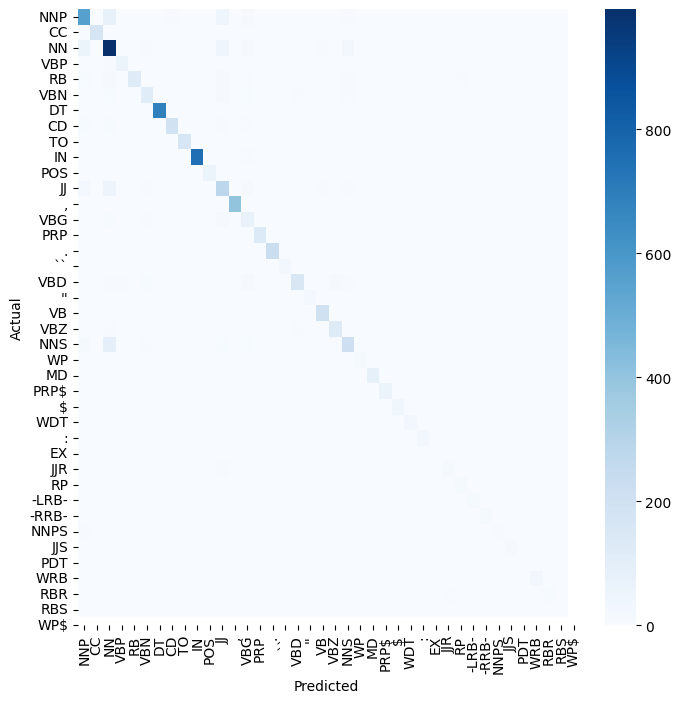

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8, 8))
tagset = [train.tagset.idx2word()[i] for i in range(len(train.tagset))]

# Compute the confusion matrix
cm = confusion_matrix(targets, preds)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=False, cmap='Blues', fmt='g', xticklabels=tagset, yticklabels=tagset)

# Set the axis labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()